In [109]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.wcs import WCS
from astropy.visualization import SqrtStretch, imshow_norm, LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy.interpolate import griddata
from scipy.signal import convolve2d
from scipy.optimize import minimize
import matplotlib.pylab as pylab
import nestle
from multiprocessing import Pool
from dynesty import NestedSampler
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc
from lenstronomy.LensModel import lens_model

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
plt.style.use("science")

In [116]:
SNR = 5.098 # known from original fits file
galfit_data = fits.open("../data/blocks1.fits")
im = galfit_data[3].data
wcs= WCS(galfit_data[1].header)
psf = fits.open("../data/rxj1131_psf1.fits")[0].data
psf2 = fits.open("../data/tiny_psf00_psf.fits")[0].data
im[im < 0] = 0

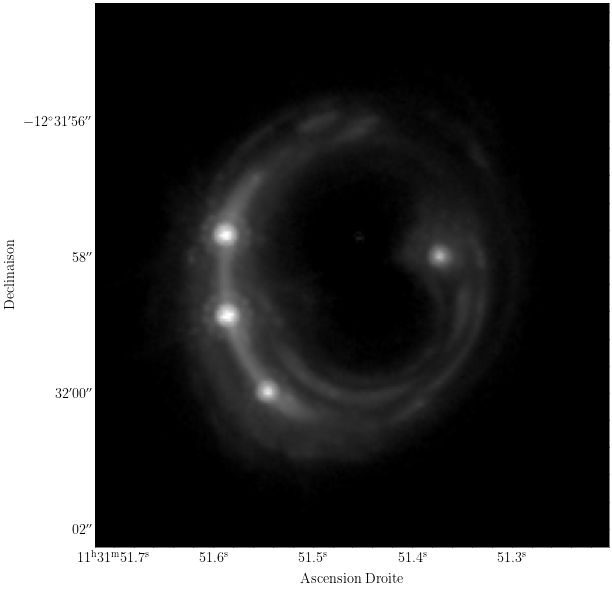

In [65]:
plt.figure(figsize=(10, 10))
plt.subplot(projection=wcs)
plt.imshow(im, cmap="gray", norm=ImageNormalize(stretch=LogStretch()))#, norm=ImageNormalize(stretch=SqrtStretch()))
ax = plt.gca()
ax.set_xlabel('Ascension Droite')
ax.set_ylabel('Declinaison');

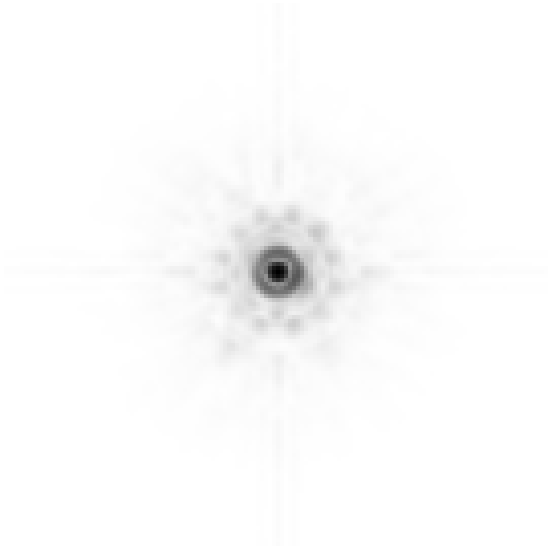

In [122]:
plt.figure(figsize=(10, 10))
plt.imshow(psf2, cmap="gray_r", norm=ImageNormalize(stretch=LogStretch()), origin="lower")
plt.axis("off")
plt.savefig("../latex/beamer_lens/figures/tiny_psf.png")

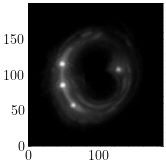

In [67]:
# further remove the central pixels for fitting
good_pixel_map = np.ones_like(im)
good_pixel_map[90:120, 80:106] = 0
plt.imshow(im * good_pixel_map, cmap="gray", norm=ImageNormalize(stretch=LogStretch()), origin="lower")#, norm=ImageNormalize(stretch=SqrtStretch()))

In [78]:
# source_grid
# lens_grid

_lens_model = lens_model.LensModel(["SPEMD"])
def NIE_forward_model(params, intensity, source_grid, lens_grid):
    x0l, y0l, e, phi, x_c, r_ein, x0, y0, width = params
    # x0l : ra of lens (in as)
    # y0l: dec of lens (in as)
    # r_ein: Einstein radius (in mas)
    # e: ellipticity parameter
    # phi: orientation of the lens [0, pi]
    # x_c: central radius
    # x0, y0: position of the source
    # width: width of the source
    params = [{
        "theta_E": r_ein,
        "gamma": 2,
        "e1": e,
        "e2": 0,
        "s_scale": x_c,
        "center_x": x0l,
        "center_y": y0l
         }]
    def psi(grid):
        theta1 = grid[:, 0]/r_ein
        theta2 = grid[:, 1]/r_ein
        return np.sqrt(1/(1 - e)*theta1**2 + (1 - e)*theta2**2 + x_c**2)

    def grad_psi(grid):
        theta1 = grid[:, 0]
        theta2 = grid[:, 1]
        p = psi(grid)
        grad1 =  theta1 / p / (1 - e)
        grad2 =  (1 - e) * theta2 / p
        return np.column_stack([grad1, grad2])

    def rotate(grid, phi):
        rho = np.hypot(grid[:, 0], grid[:, 1])
        varphi = np.angle(grid[:, 0] + 1j*grid[:, 1]) - phi
        rotated_theta1 = rho * np.cos(varphi)
        rotated_theta2 = rho * np.sin(varphi)
        return np.column_stack([rotated_theta1, rotated_theta2])

    def source_model(source_grid, intensity, x0, y0, width): # symmetric gaussian profile
        rho = np.hypot(source_grid[:, 0] - x0, source_grid[:, 1] - y0)
        return intensity * np.exp(-0.5*rho**2/width**2)/2/np.pi/width**2
    
    theta = rotate(lens_grid, phi)
    theta1 = theta[:, 0] - x0l
    theta2 = theta[:, 1] - y0l
    lens_grid = np.column_stack([theta1, theta2])
    
    alpha = grad_psi(lens_grid) # deflection angles
    beta  = theta - alpha # lens equation
    I     = source_model(source_grid, intensity, x0, y0, width)
    I_lens = griddata(source_grid, I, (beta[:, 0], beta[:, 1]), method="linear") # ray trace source profile to lens plane
    return I_lens
    
def likelihood(params, image, sigma_vector, psf, intensity, source_grid, lens_grid, pixel_map):
    I_reconstructed = NIE_forward_model(params, intensity, source_grid, lens_grid)
#     I_reconstructed += np.random.normal(0, sigma_vector.ravel(), size=I_reconstructed.shape)
    I_reconstructed = convolve2d(I_reconstructed.reshape(image.shape), psf, mode="same").ravel()
    chi_squared = -0.5 * np.mean((I_reconstructed/I_reconstructed.sum() - image.ravel()/image.sum())**2)
    return chi_squared


<ipython-input-79-f5a1ce8a57a4>:10: RuntimeWarning: divide by zero encountered in log
  plt.imshow(np.log(good_pixel_map * im))


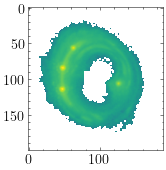

In [79]:
#lensgrid -> place center in the bottom left corner, not in the center of the image
N, M = im.shape
y = np.arange(N) #- N//2. + 0.5 * ((N + 1) % 2)
x = np.arange(M) #- M//2. + 0.5 * ((M + 1) % 2)
x, y = np.meshgrid(x, y)
rho = np.hypot(x, y)

good_pixels_map = np.zeros_like(rho, dtype=bool)
good_pixels_map[(rho > 25)] = True 
plt.imshow(np.log(good_pixel_map * im))

In [80]:
# sky coordinate are relative to corner in pixel space
lens_sky = wcs.pixel_to_world(x.ravel(), y.ravel())
# place center in the middle of the array
x_lens = (lens_sky.ra - lens_sky.ra[M//2]).to(u.arcsec).value
y_lens = (lens_sky.dec - lens_sky.dec[M * N // 2]).to(u.arcsec).value
lens_grid = np.column_stack([x_lens.ravel(), y_lens.ravel()])
rho_lens = np.hypot(x_lens, y_lens)
fov = 2 * rho_lens.max()
fov

11.106699410950242

In [81]:
# make fov of source plane about half as small
fov_source = fov/2
# source grid
Ns = N//2 # also make grid with about 4 times less pixel
Ms = M//2
ys = np.linspace(-1, 1, Ns) * fov_source
xs = np.linspace(-1, 1, Ms) * fov_source
xs, ys = np.meshgrid(xs, ys)
source_grid = np.column_stack([xs.ravel(), ys.ravel()])

In [82]:
# test forward, try to find a warm start
x0l = 0.1
y0l = 0.1
e = 0.15
phi = 0.3
x_c = 0.5
r_ein = 1.5
x0 = 0.1
y0 = 0
width = 0.2
intensity = im.sum()/500
params = x0l, y0l, e, phi, x_c, r_ein, x0, y0, width 
sigma = np.array([im.mean() / SNR])
I = NIE_forward_model(params, intensity, source_grid, lens_grid)
I = convolve2d(I.reshape(im.shape), psf, mode="same").ravel()

# plt.figure(figsize=(8, 8))
# plt.imshow(I.reshape([N, M]), origin="lower", cmap="hot")
# plt.imshow(im)

In [83]:
bounds = [
    [-0.2, 0.2], #x0l
    [-0.2, 0.2], # y0l
    [0., 0.2], # e
    [0, np.pi], # phi
    [0.1, 0.9], #x_c 
    [1, 5], # r_ein
    [-0.2, 0.2], #x0
    [-0.2, 0.2], # y0
    [0.01, 0.5] # width
]

def prior_transform(x, bounds=bounds): # uniform distribution
    return [(bounds[i][1] - bounds[i][0]) * x[i] + bounds[i][0] for i in range(x.size)]

# test: use I
def loglike(x):
    return likelihood(x, im, sigma, psf, intensity, source_grid, lens_grid, good_pixels_map.ravel() )
# res = nestle.sample(loglike, prior_transform, ndim=len(bounds), npoints=10)
ndim = len(bounds)
with Pool(8) as pool:
    sampler = DynamicNestedSampler(loglike, prior_transform, ndim, pool=pool, queue_size=10, nlive=3000)
    sampler.run_nested(maxiter=5000)

5452it [14:50,  6.12it/s, batch: 5 | bound: 0 | nc: 1 | ncall: 24191 | eff(%): 22.537 | loglstar:   -inf < -0.000 < -0.000 | logz: -0.001 +/-  0.084 | stop:    nan]            


(<Figure size 1152x1152 with 4 Axes>,
 array([<AxesSubplot:xlabel='$-\\ln X$', ylabel='Live Points'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Likelihood\n(normalized)'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Importance\nWeight PDF'>,
        <AxesSubplot:xlabel='$-\\ln X$', ylabel='Evidence'>], dtype=object))

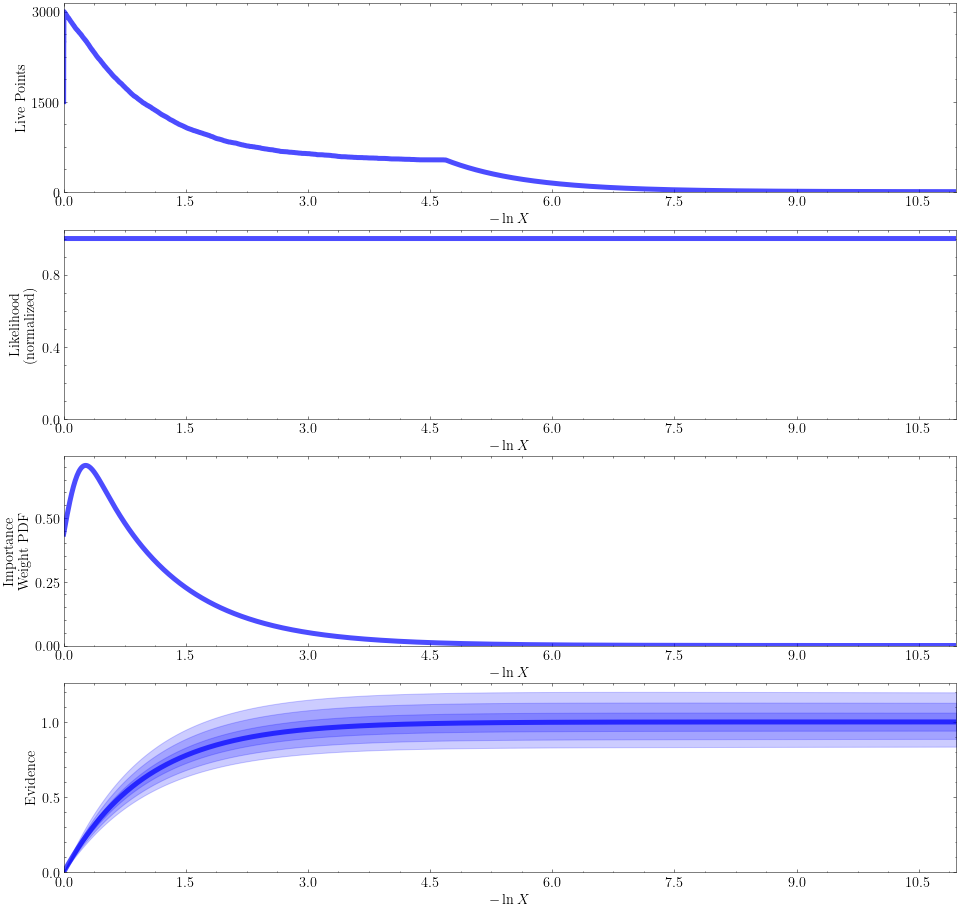

In [84]:
dyplot.runplot(sampler.results)

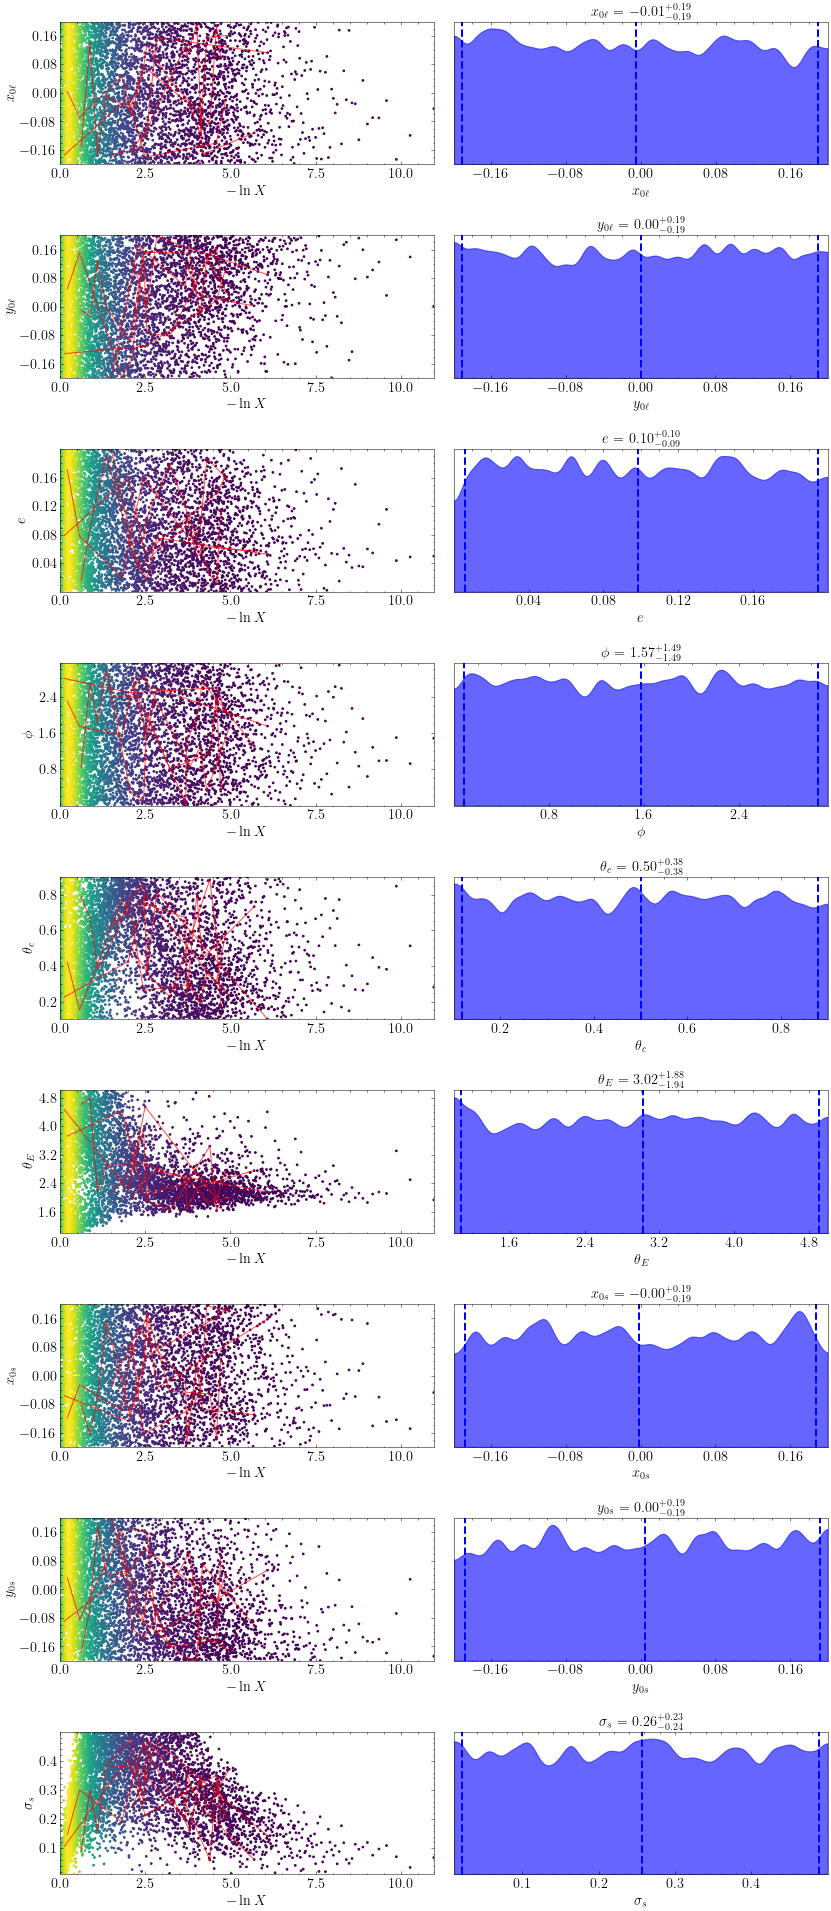

In [85]:
fig, axs = dyplot.traceplot(sampler.results, show_titles=True,
                             trace_cmap='viridis', connect=True,
                             connect_highlight=range(5),
                            labels=[r"$x_{0\ell}$", r"$y_{0\ell}$", r"$e$", r"$\phi$", r"$\theta_c$", r"$\theta_E$", r"$x_{0s}$", r"$y_{0s}$", r"$\sigma_s$"]
                           );
fig.tight_layout(pad=2.0)

In [87]:
res = sampler.results
samples, weights = res.samples, np.exp(res.logwt - res.logz[-1])
mean, cov = dyfunc.mean_and_cov(samples, weights)

In [106]:
# I2 = NIE_forward_model(mean, intensity, source_grid, lens_grid)
# I2 = convolve2d(I2.reshape(im.shape), psf, mode="same").ravel()
# plt.figure(figsize=(8, 8))
# plt.imshow(I2.reshape([N, M]), cmap="gray", norm=ImageNormalize(stretch=LogStretch()))

In [107]:
best = res.samples[np.argmax(res.logl)]

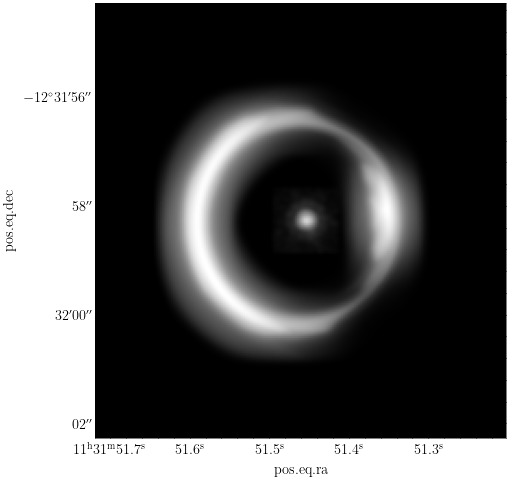

In [108]:
I2 = NIE_forward_model(best, intensity, source_grid, lens_grid)
I2 = convolve2d(I2.reshape(im.shape), psf, mode="same").ravel()
plt.figure(figsize=(8, 8))
plt.subplot(projection=wcs)
plt.imshow(I2.reshape([N, M]), cmap="gray", norm=ImageNormalize(stretch=LogStretch()))